In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#from google.colab import files
import io, requests, zipfile
from sklearn.cluster import KMeans

Read Parimah's data with a little preparation (for instance I removed '$' and ',' for more convenience)

In [2]:
data = pd.read_csv('/Users/apple/Desktop/COVID-19-economical-effects/risk_income_data.csv')
n_s = 100
data.head()

,occ,risk,income,number,medical staff or not
0,Waiters and Waitresses,43.6,21780,2582410,0
1,Amusement and Recreation Attendants,56.0,22260,319890,0
2,"Ushers, Lobby Attendants, and Ticket Takers",51.1,22260,133970,0
3,Dining Room and Cafeteria Attendants and Barte...,45.5,22270,455700,0
4,"Counter Attendants, Cafeteria, Food Concession...",39.5,22330,473860,0


In [3]:
print(data.shape)

(100, 5)


In [4]:
#keep the features (risk, income and number) in X_p and scale them with it's corresponding maximum value
X = data.drop('occ', axis=1)
X_max = X.max(axis = 0)
X = X / X_max

medic_list = X[X['medical staff or not'] == 1]
X = X[X['medical staff or not'] != 1]

medic_list = medic_list.drop('medical staff or not', axis=1)
X = X.drop('medical staff or not', axis=1)

print(X.shape)
print(medic_list.shape)

(68, 3)
(32, 3)


In the following we intend to:
1-classify jobs to get a sense of what we are working with. We have so far 3 dimensions. We can classify jobs only base on [risk, income] or we can classify them in a 3d space where the features are [risk, income, number]
2-for each 2 pairs of features, plot them in different colors.

We use Unsupervised clustering KMeans method. MUST INDICATE THE NUMBER OF CLUSTERS.

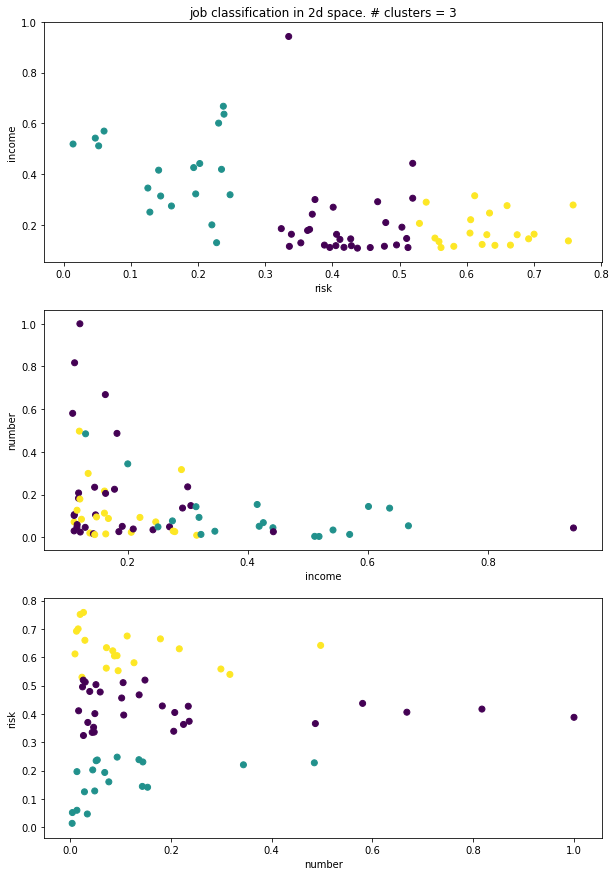

In [5]:
#Unsupervised clustering, ONE features (risk), THREE clusters
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize = (10,15))
axs = [ax1,ax2,ax3]
X_p = X.drop('income', axis = 1)
X_p = X_p.drop('number', axis = 1)

N_clusters = 3
N_space = 2

y_pred = KMeans(n_clusters=3, random_state=1).fit_predict(X_p)
features = ['risk', 'income', 'number']
features_r = ['income', 'number', 'risk']

for i in range(3):
    feat_1 = features[i]
    feat_2 = features_r[i]
    axs[i].scatter(X[feat_1],  X[feat_2], c=y_pred)
    axs[i].set_xlabel(feat_1)
    axs[i].set_ylabel(feat_2)
    if i == 0:
        axs[i].set_title('job classification in {}d space. # clusters = {}'.format(N_space, N_clusters))


Based on the last plot, one can ignore the "green" cluster (AKA medical staff). This group's characteristics: [High income, High risk, Low number]

In [6]:
X['risk_groups'] = y_pred
X['risk_groups'].head()

medic_list['risk_groups'] = len(medic_list) * [3]

In [7]:
X_final = [X,medic_list]
X_final = pd.concat(X_final)
X_final.shape


(100, 4)

In [10]:
# determining the average risk and income in each group

mean_risk = [0,0,0,0]
mean_income = [0,0,0,0]
pop_per_gr = [0,0,0,0]
mean_risk2 = [0,0,0,0]
mean_income2 = [0,0,0,0]
pop_per_gr2 = [0,0,0,0]

for i in range(len(X_final)):
    if X_final['risk_groups'][i] == 0:
        mean_risk[0] += X_final['risk'][i] * X_final['number'][i] 
        mean_income[0] += X_final['income'][i] * X_final['number'][i]  
        pop_per_gr[0] += X_final['number'][i]       
        mean_risk2[0] += (X_final['risk'][i] ) **2 * X_final['number'][i]
        mean_income2[0] += (X_final['income'][i] ) ** 2 * X_final['number'][i]
        
    if X_final['risk_groups'][i] == 1:
        mean_risk[1] += X_final['risk'][i] * X_final['number'][i]
        mean_income[1] += X_final['income'][i] * X_final['number'][i]    
        pop_per_gr[1] += X_final['number'][i]
        mean_risk2[1] += (X_final['risk'][i]) **2  * X_final['number'][i]
        mean_income2[1] += (X_final['income'][i] ) ** 2 * X_final['number'][i]
        
    if X_final['risk_groups'][i] == 2:
        mean_risk[2] += X_final['risk'][i] * X_final['number'][i]
        mean_income[2] += X_final['income'][i] * X_final['number'][i]
        pop_per_gr[2] += X_final['number'][i]
        mean_risk2[2] += (X_final['risk'][i] ) **2 * X_final['number'][i]
        mean_income2[2] += (X_final['income'][i] ) ** 2* X_final['number'][i]
        
    if X_final['risk_groups'][i] == 3:
        mean_risk[3] += X_final['risk'][i] * X_final['number'][i]
        mean_income[3] += X_final['income'][i] * X_final['number'][i]
        pop_per_gr[3] += X_final['number'][i]
        
        mean_risk2[3] += (X_final['risk'][i] ) **2 * X_final['number'][i]
        mean_income2[3] += (X_final['income'][i] ) ** 2* X_final['number'][i]
        
        
mean_risk = np.array(mean_risk) / np.array(pop_per_gr)
mean_income = np.array(mean_income) /np.array(pop_per_gr)

std_risk = np.sqrt(abs(mean_risk**2 - mean_risk2 / np.array(pop_per_gr)))
std_income = np.sqrt(abs(mean_income**2 -  mean_income2 / np.array(pop_per_gr)))

group_labels = ['high risk', 'medium risk', 'low risk', 'medical staff']

In [11]:
group_labels


['high risk', 'medium risk', 'low risk', 'medical staff']

In [23]:
d = pd.DataFrame()

d['risk'] = np.round(mean_risk, 2)
d['std_risk'] = np.round(std_risk, 2)

d['average income'] = np.round(mean_income, 2)
d['std income'] = np.round(std_income, 2)

d['population'] = np.round(pop_per_gr,2)

d['group label'] = group_labels


d

,group label,risk,std_risk,average income,std income,population
0,medium risk,0.41,0.04,0.16,0.09,5.94
1,low risk,0.20,0.05,0.32,0.18,1.95
2,high risk,0.61,0.05,0.17,0.06,2.39
3,medical staff,0.78,0.11,0.30,0.16,2.28


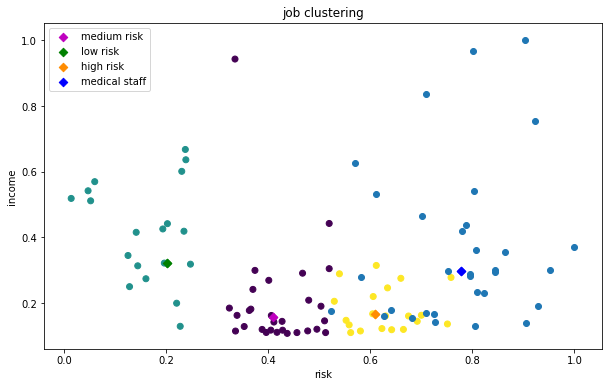

In [24]:
# plotting income vs risk for each grous and their average risks and incomes

fig, ax = plt.subplots(figsize = (10,6))
ax.set_xlabel('risk')
ax.set_ylabel('income')
ax.set_title('job clustering')

colors = ['m','green','darkorange','blue']
for i in range(4):
    ax.scatter(mean_risk[i], mean_income[i], color = colors[i] ,marker = 'D', label = group_labels[i])
ax.legend()

ax.scatter(X_final['risk'][:68],  X_final['income'][:68], c=y_pred)
ax.scatter(X_final['risk'][68:],  X_final['income'][68:])

for i in range(4):
    ax.scatter(mean_risk[i], mean_income[i], color = colors[i] ,marker = 'D')